# Bootstrap Aggregating without online sampling
* Not seperating by WSI

In [1]:
import os
import sys
import glob
import random
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data
import torchvision.models as models
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

SEED = 101
np.random.seed(SEED)
from torchvision import datasets, models, transforms

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Add the src directory for functions
src_dir = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'src')
print(src_dir)
sys.path.append(src_dir)

# import my functions:
from WSI_pytorch_utils import*

fast_ai_dir = '/media/rene/Data/fastai/'
sys.path.append(fast_ai_dir)

torch.cuda.set_device(0)
print(torch.cuda.is_available())
print(torch.cuda.current_device())

/media/rene/Data/camelyon/src
True
0


## Make dataset 
* csv with locations pointing to the right images to sample

In [2]:
# # reproduce
# cp -r tiles_224_100t/train/tumor/. tiles_224_100t_all
# cp -r tiles_224_100t/train/normal/. tiles_224_100t_all
# cp -r tiles_224_100t/valid/tumor/. tiles_224_100t_all
# cp -r tiles_224_100t/valid/normal/. tiles_224_100t_all

In [2]:
# get data
data_loc = '/media/rene/Data/camelyon_out/tiles_224_100t_all'
all_imgs = glob.glob(data_loc+'/*')
img_names = [loc.rsplit('/', 1)[-1] for loc in all_imgs]

# load train valid split
ttv_split = np.load('/media/rene/Data/camelyon/other/ttv_split.p')
normal_valid = ttv_split['normal_vaild_idx']
tumor_valid = ttv_split['tumor_vaild_idx']
normal_train = list(range(1, 161))
normal_train = [num for num in normal_train if num not in normal_valid]
tumor_train = list(range(1, 111))
tumor_train = [num for num in tumor_train if num not in tumor_valid]

In [3]:
# get classes corresponding to each file
def get_label(name):
    if name.rsplit('_', 1)[-2][-5:]=='tumor':
        label = 'tumor'
    else: 
        label = 'normal'
    return label

classes = [get_label(name) for name in img_names]

# make csv
labels_df = pd.DataFrame(
    {'file_name': img_names,
     'label': classes
    })

labels_df.to_csv('/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_labels.csv', index = False)

In [5]:
# get the validation indices from the big list
def is_validation(name, normal_valid, tumor_valid):
    normal_valid = [int(x) for x in normal_valid]
    tumor_valid = [int(x) for x in tumor_valid]
    num = int(name.split('_', 1)[1].split('_', 1)[0])
    
    if classes[idx] == 'normal':
        return num in normal_valid
    
    elif classes[idx] == 'tumor':
        return num in tumor_valid
    else:
        raise ValueError("tile isn't tumor or non tumor")

valid_idxs = []
for idx, name in enumerate(img_names):
    if is_validation(name, normal_valid, tumor_valid):
        valid_idxs.append(idx)
        
# with open('/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_val_idxs.p', 'wb') as fp:
#     pickle.dump(valid_idxs, fp)

def make_validation_mask(data_df, normal_valid, tumor_valid):
    img_names = data_df['file_name'].tolist()
    valid_idxs = [is_validation(name, normal_valid, tumor_valid) for name in img_names]
    return valid_idxs

In [50]:
# valid_idxs = make_validation_mask(subset_labels_df, normal_valid, tumor_valid)
# print(np.sum(np.array(valid_idxs)))

NameError: name 'subset_labels_df' is not defined

### Single model
Use a single model (resnet50) to check:
* How does the number of models affect performance?
* How does the downsample rate for bagging effect performance?

In [ ]:
# blindly subsetting
models_arch = resnet50
models_name = 'resnet50'
lr=np.array([1e-3,5e-3,1e-2])

sz = 224
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other'
train_folder = '/media/rene/Data/camelyon_out/tiles_224_100t_all'
# val_idxs = pickle.load( open( "/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_val_idxs.p", "rb" ) )

for i in tqdm(range(10)):
    # create the new csv and save it
    subset_labels_df = labels_df.sample(frac=0.5)
    subset_labels_df.to_csv('/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp.csv',  
                            index = False)
    csv_fname = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp.csv'
    
    # get the validation indices based on this
    val_idxs = make_validation_mask(subset_labels_df, normal_valid, tumor_valid)

    tfms = tfms_from_model(models_arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
    data = ImageClassifierData.from_csv(PATH, train_folder, csv_fname, tfms=tfms, 
                                        val_idxs=val_idxs, bs=64)
    learn = ConvLearner.pretrained(models_arch, data, precompute=False)
    
    lr =.001
    learn.fit(lr, 1, cycle_len=1, cycle_mult=1) # train last few layers
    lrs = np.array([lr/4,lr/2,lr])
    learn.unfreeze()
    learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name+'_half_'+str(i)) # train whole model


  0%|          | 0/10 [00:00<?, ?it/s]

epoch      trn_loss   val_loss   accuracy                    
    0      0.258123   0.236092   0.901118  



epoch      trn_loss   val_loss   accuracy                    
    0      0.228827   0.195023   0.917085  
    1      0.190916   0.171231   0.92792                     
    2      0.173516   0.167493   0.930771                    
    3      0.164284   0.157176   0.936702                    
    4      0.170038   0.151984   0.937272                    
    5      0.152887   0.148405   0.937614                    
    6      0.151523   0.146917   0.940237                    



 10%|█         | 1/10 [1:16:35<11:29:15, 4595.09s/it]

epoch      trn_loss   val_loss   accuracy                    
    0      0.256658   0.228447   0.903998  



epoch      trn_loss   val_loss   accuracy                    
    0      0.220711   0.185948   0.924136  
    1      0.193467   0.165171   0.934206                    
    2      0.172577   0.161619   0.935479                    
    3      0.159101   0.152919   0.943812                    
    4      0.154825   0.145336   0.943697                    
    5      0.154532   0.143157   0.947285                    
    6      0.151981   0.142732   0.947516                    



 20%|██        | 2/10 [2:08:30<8:34:02, 3855.33s/it] 

epoch      trn_loss   val_loss   accuracy                    
    0      0.271743   0.21609    0.908731  



epoch      trn_loss   val_loss   accuracy                    
    0      0.201858   0.175385   0.92925   
    1      0.186081   0.158632   0.936657                    
    2      0.184647   0.153031   0.938509                    
    3      0.170445   0.145281   0.94256                     
    4      0.166659   0.135638   0.946611                    
    5      0.161266   0.134885   0.945801                    
    6      0.160088   0.133546   0.948116                    



 30%|███       | 3/10 [2:52:00<6:41:21, 3440.17s/it]

epoch      trn_loss   val_loss   accuracy                    
    0      0.269427   0.236721   0.901101  



epoch      trn_loss   val_loss   accuracy                    
    0      0.216792   0.191496   0.922295  
    1      0.188173   0.168215   0.932495                    
    2      0.183503   0.165024   0.932726                    
    3      0.182143   0.157321   0.93805                     
    4      0.159494   0.152746   0.940264                    
    5      0.158551   0.150859   0.939208                    
    6      0.138734   0.14692    0.942217                    



 40%|████      | 4/10 [3:31:57<5:17:55, 3179.31s/it]

epoch      trn_loss   val_loss   accuracy                    
    0      0.258413   0.23888    0.899931  



epoch      trn_loss   val_loss   accuracy                    
    0      0.228721   0.195452   0.917394  
    1      0.344862   0.229207   0.908088                    
    2      0.29135    0.230812   0.908433                    
    3      0.246764   0.224749   0.910731                    
    4      0.250404   0.227592   0.911075                    
    5      0.228938   0.224816   0.910846                    



 50%|█████     | 5/10 [4:10:51<4:10:51, 3010.27s/it]

    6      0.280751   0.267344   0.884076  



epoch      trn_loss   val_loss   accuracy                    
    0      0.26181    0.233402   0.90007   



epoch      trn_loss   val_loss   accuracy                    
    0      0.22671    0.187654   0.916161  
    1      0.195313   0.163682   0.928638                    
    2      0.176339   0.15783    0.934468                    
    3      0.172505   0.147125   0.939249                    
    4      0.157038   0.144134   0.944496                    
    5      0.163454   0.138813   0.945546                    



 60%|██████    | 6/10 [4:49:28<3:12:58, 2894.70s/it]

    6      0.160142   0.139144   0.944613  



epoch      trn_loss   val_loss   accuracy                    
    0      0.264015   0.233757   0.901736  



epoch      trn_loss   val_loss   accuracy                    
    0      0.218438   0.195513   0.920131  
    1      0.183886   0.165447   0.931358                    
    2      0.180778   0.161018   0.933094                    
    3      0.184149   0.150061   0.939576                    
    4      0.159214   0.145378   0.941891                    
    5      0.153353   0.144101   0.942354                    
    6      0.144702   0.141865   0.94328                     



 70%|███████   | 7/10 [5:27:57<2:20:33, 2811.07s/it]

epoch      trn_loss   val_loss   accuracy                    
    0      0.269996   0.230409   0.903193  



epoch      trn_loss   val_loss   accuracy                    
    0      0.213426   0.1894     0.924706  
    1      0.192626   0.167762   0.934556                    
    2      0.189549   0.167321   0.931612                    
    3      0.17218    0.158888   0.937274                    
    4      0.159322   0.153381   0.9375                      
    5      0.14734    0.148342   0.941123                    
 21%|██        | 136/645 [00:59<03:43,  2.28it/s, loss=0.152]

In [ ]:
# blindly subsetting
models_arch = resnet50
models_name = 'resnet50'
lr=np.array([1e-3,5e-3,1e-2])

sz = 224
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other'
train_folder = '/media/rene/Data/camelyon_out/tiles_224_100t_all'
# val_idxs = pickle.load( open( "/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_val_idxs.p", "rb" ) )

for i in tqdm(range(10)):
    # create the new csv and save it
    subset_labels_df = labels_df.sample(frac=0.25)
    subset_labels_df.to_csv('/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp.csv',  
                            index = False)
    csv_fname = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp.csv'
    
    # get the validation indices based on this
    val_idxs = make_validation_mask(subset_labels_df, normal_valid, tumor_valid)

    tfms = tfms_from_model(models_arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
    data = ImageClassifierData.from_csv(PATH, train_folder, csv_fname, tfms=tfms, 
                                        val_idxs=val_idxs, bs=64)
    learn = ConvLearner.pretrained(models_arch, data, precompute=False)
    
    lr =.001
    learn.fit(lr, 1, cycle_len=1, cycle_mult=1) # train last few layers
    lrs = np.array([lr/4,lr/2,lr])
    learn.unfreeze()
    learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name+'_quarter_'+str(i)) # train whole model

In [ ]:
# blindly subsetting
models_arch = resnet50
models_name = 'resnet50'
lr=np.array([1e-3,5e-3,1e-2])

sz = 224
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other'
train_folder = '/media/rene/Data/camelyon_out/tiles_224_100t_all'
# val_idxs = pickle.load( open( "/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_val_idxs.p", "rb" ) )

for i in tqdm(range(10)):
    # create the new csv and save it
    subset_labels_df = labels_df.sample(frac=1)
    subset_labels_df.to_csv('/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp.csv',  
                            index = False)
    csv_fname = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp.csv'
    
    # get the validation indices based on this
    val_idxs = make_validation_mask(subset_labels_df, normal_valid, tumor_valid)

    tfms = tfms_from_model(models_arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
    data = ImageClassifierData.from_csv(PATH, train_folder, csv_fname, tfms=tfms, 
                                        val_idxs=val_idxs, bs=64)
    learn = ConvLearner.pretrained(models_arch, data, precompute=False)
    
    lr =.001
    learn.fit(lr, 1, cycle_len=1, cycle_mult=1) # train last few layers
    lrs = np.array([lr/4,lr/2,lr])
    learn.unfreeze()
    learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name+'_full_'+str(i)) # train whole model

## Subsample data csv for bagging
* Try doing it slide wise, as well as totally randomly
* Use the full validation set
* Bagging is randomly sampling the wsis, so models will be trained on some of the same data
* This won't be exactly 50%, but who cares

In [2]:
# get the indices of slides to use
def make_sample(labels_df, normal_train, tumor_train, downsample=2):
    normal_train_subset = random.sample(normal_train, int(len(normal_train)/int(downsample)))
    normal_train_subset = [int(x) for x in normal_train_subset]
    
    tumor_train_subset = random.sample(tumor_train, int(len(tumor_train)/int(downsample)))
    tumor_train_subset = [int(x) for x in tumor_train_subset]
    
    drop_rows = []
    for index, row in labels_df.iterrows():
        label = row['label']
        num = int(row['file_name'].split('_', 1)[1].split('_', 1)[0])
        
        if label == 'normal' and num not in normal_train_subset:
            drop_rows.append(index)
        elif label == 'tumor' and num not in tumor_train_subset:
            drop_rows.append(index)
    
    subset_labels_df = labels_df.drop(labels_df.index[drop_rows])
    return subset_labels_df

## Test
*** Don't need to re-run the top stuff ***
* Check the acc of the individual models
* Check how adding models increases acc

In [8]:
def bagging_ensemble_acc(models_arch, models_name, PATH, train_folder, csv_fname, weights=None):
    # weights must be in the same order corresponding to model
    # weights only used for the final ensemble, not the intermediate ones
    if weights is None:
        weights = [1/len(models_arch)]*len(models_arch)
    all_preds = []
    all_y = []
    int_acc_list = []
    
    for idx, arch in enumerate(models_arch):
        if arch in [inceptionresnet_2, inception_4]:
            sz = 299
        else:
            sz = 224

        tfms = tfms_from_model(arch, sz, aug_tfms=None, max_zoom=1)
        
        # do data from path, because this is the same split, just doesn't req
        # get the validation indices based on this
        data = ImageClassifierData.from_csv(PATH, train_folder, csv_fname, tfms=tfms, 
                                            val_idxs=val_idxs, bs=64)
        
        model_loc = os.path.join(PATH, 'models', models_name[idx])
        learn = ConvLearner.pretrained(arch, data, precompute=False)
        print(learn.model)
        learn.load(model_loc)
        # this returns log probs, but don't need to do anything because just taking the argmax
        preds, y = learn.predict_with_targs(is_test=False)
        print(models_name[idx], ':   ', accuracy_np(preds, y))
        all_preds.append(preds)
        all_y.append(y)

        curr_preds = np.array(all_preds)
        curr_probs = np.average(np.exp(curr_preds), axis=0)
        int_acc = accuracy_np(curr_probs, y)
        int_acc_list.append(int_acc)
        print(models_name[idx], 'int acc:   ', int_acc_list)

    all_preds = np.array(all_preds)
    probs = np.average(np.exp(all_preds), axis=0, weights=weights)
    print(accuracy_np(probs, all_y))
    return int_acc

def bagging_ensemble_acc_dir(models_arch, models_name, models_path, PATH, weights=None):
    # weights must be in the same order corresponding to model
    # weights only used for the final ensemble, not the intermediate ones
    if weights is None:
        weights = [1/len(models_arch)]*len(models_arch)
    all_preds = []
    all_y = []
    int_acc_list = []
    
    for idx, arch in enumerate(models_arch):
        if arch in [inceptionresnet_2, inception_4]:
            sz = 299
        else:
            sz = 224

        tfms = tfms_from_model(arch, sz, aug_tfms=None, max_zoom=1)
        
        # do data from path, because this is the same split, just doesn't req
        # get the validation indices based on this
        data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=64)

        model_loc = os.path.join(models_path, 'models', models_name[idx])
        learn = ConvLearner.pretrained(arch, data, precompute=False)
        learn.load(model_loc)
        # this returns log probs, but don't need to do anything because just taking the argmax
        preds, y = learn.predict_with_targs(is_test=False)
        print(models_name[idx], ':   ', accuracy_np(preds, y))
        all_preds.append(preds)
        all_y.append(y)

        curr_preds = np.array(all_preds)
        curr_probs = np.average(np.exp(curr_preds), axis=0)
        int_acc = accuracy_np(curr_probs, y)
        int_acc_list.append(int_acc)
        print(models_name[idx], 'int acc:   ', int_acc)

    all_preds = np.array(all_preds)
    probs = np.average(np.exp(all_preds), axis=0, weights=weights)
    print(accuracy_np(probs, all_y))
    return int_acc_list

resnet50_full_0 :    0.9544910179640719
resnet50_full_0 int acc:    0.9544910179640719
resnet50_full_1 :    0.9577844311377246
resnet50_full_1 int acc:    0.9562275449101797
resnet50_full_2 :    0.9548502994011976
resnet50_full_2 int acc:    0.9567065868263473
resnet50_full_3 :    0.9566467065868264
resnet50_full_3 int acc:    0.9575449101796407
resnet50_full_4 :    0.9568862275449102
resnet50_full_4 int acc:    0.9579640718562874
resnet50_full_5 :    0.9563473053892215
resnet50_full_5 int acc:    0.958502994011976
resnet50_full_6 :    0.9556886227544911
resnet50_full_6 int acc:    0.9592215568862276
resnet50_full_7 :    0.9576646706586827
resnet50_full_7 int acc:    0.958622754491018
resnet50_full_8 :    0.9573053892215568
resnet50_full_8 int acc:    0.9592215568862276
resnet50_full_9 :    0.9553293413173652
resnet50_full_9 int acc:    0.9591616766467066
0.9591616766467066


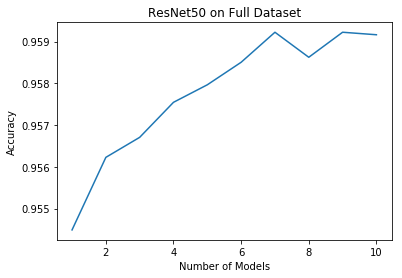

In [21]:
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t/'
models_path = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other'
models_arch = [resnet50]*10
models_name = ['resnet50_full_'+str(i)for i in range (10)]

int_acc = bagging_ensemble_acc_dir(models_arch, models_name, models_path, PATH, weights=None)
x = list(range(1, 11))

plt.plot(x, int_acc)
plt.title('ResNet50 on Full Dataset')
plt.xlabel('Number of Models')
plt.ylabel('Accuracy')
plt.show()

resnet50_half_0 :    0.9482634730538922
resnet50_half_0 int acc:    0.9482634730538922
resnet50_half_1 :    0.9511976047904191
resnet50_half_1 int acc:    0.9507185628742515
resnet50_half_2 :    0.9461077844311377
resnet50_half_2 int acc:    0.9505389221556886
resnet50_half_3 :    0.9480838323353293
resnet50_half_3 int acc:    0.9508982035928144
resnet50_half_4 :    0.9301197604790419
resnet50_half_4 int acc:    0.9479640718562874
resnet50_half_5 :    0.9467664670658683
resnet50_half_5 int acc:    0.948443113772455
resnet50_half_6 :    0.9468263473053892
resnet50_half_6 int acc:    0.948562874251497
resnet50_half_7 :    0.9488023952095809
resnet50_half_7 int acc:    0.9486826347305389
resnet50_half_8 :    0.948562874251497
resnet50_half_8 int acc:    0.9489221556886227
resnet50_half_9 :    0.9459880239520958
resnet50_half_9 int acc:    0.9491017964071856
0.9491017964071856


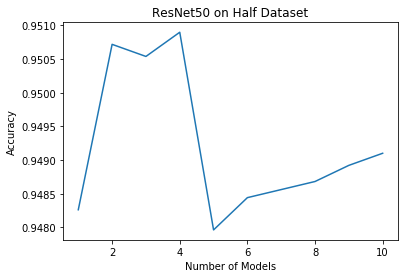

In [27]:
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t/'
models_path = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other'
models_arch = [resnet50]*10
models_name = ['resnet50_half_'+str(i)for i in range (10)]

int_acc = bagging_ensemble_acc_dir(models_arch, models_name, models_path, PATH, weights=None)
x = list(range(1, 11))

plt.plot(x, int_acc)
plt.title('ResNet50 on Half Dataset')
plt.xlabel('Number of Models')
plt.ylabel('Accuracy')
plt.show()

resnet50_quarter_0 :    0.9404191616766467
resnet50_quarter_0 int acc:    0.9404191616766467
resnet50_quarter_1 :    0.9418562874251497
resnet50_quarter_1 int acc:    0.9432934131736527
resnet50_quarter_2 :    0.9413173652694611
resnet50_quarter_2 int acc:    0.9445508982035928
resnet50_quarter_3 :    0.9426946107784431
resnet50_quarter_3 int acc:    0.9446706586826348
resnet50_quarter_4 :    0.941377245508982
resnet50_quarter_4 int acc:    0.9434131736526946
resnet50_quarter_5 :    0.9394011976047905
resnet50_quarter_5 int acc:    0.9438922155688623
resnet50_quarter_6 :    0.937185628742515
resnet50_quarter_6 int acc:    0.9434730538922156
resnet50_quarter_7 :    0.937185628742515
resnet50_quarter_7 int acc:    0.9432934131736527
resnet50_quarter_8 :    0.9404191616766467
resnet50_quarter_8 int acc:    0.9425149700598803
resnet50_quarter_9 :    0.9388622754491018
resnet50_quarter_9 int acc:    0.9426347305389221
0.9426347305389221


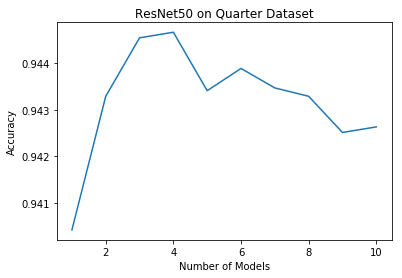

In [28]:
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t/'
models_path = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other'
models_arch = [resnet50]*10
models_name = ['resnet50_quarter_'+str(i)for i in range (10)]

int_acc = bagging_ensemble_acc_dir(models_arch, models_name, models_path, PATH, weights=None)
x = list(range(1, 11))

plt.plot(x, int_acc)
plt.title('ResNet50 on Quarter Dataset')
plt.xlabel('Number of Models')
plt.ylabel('Accuracy')
plt.show()

## Models trained data seperated by WSI

resnet50_half_wsi_0 :    0.9292814371257485
resnet50_half_wsi_0 int acc:    0.9292814371257485
resnet50_half_wsi_1 :    0.9370059880239521
resnet50_half_wsi_1 int acc:    0.9410179640718563
resnet50_half_wsi_2 :    0.9207185628742515
resnet50_half_wsi_2 int acc:    0.9390419161676646
resnet50_half_wsi_3 :    0.9362275449101797
resnet50_half_wsi_3 int acc:    0.9412574850299401
resnet50_half_wsi_4 :    0.931497005988024
resnet50_half_wsi_4 int acc:    0.9413173652694611
resnet50_half_wsi_5 :    0.9321556886227544
resnet50_half_wsi_5 int acc:    0.9419161676646707
resnet50_half_wsi_6 :    0.9020359281437126
resnet50_half_wsi_6 int acc:    0.9391616766467066
resnet50_half_wsi_7 :    0.9304790419161677
resnet50_half_wsi_7 int acc:    0.9395209580838323
resnet50_half_wsi_8 :    0.9283233532934132
resnet50_half_wsi_8 int acc:    0.9393413173652695
resnet50_half_wsi_9 :    0.9300598802395209
resnet50_half_wsi_9 int acc:    0.9398203592814371
0.9398203592814371


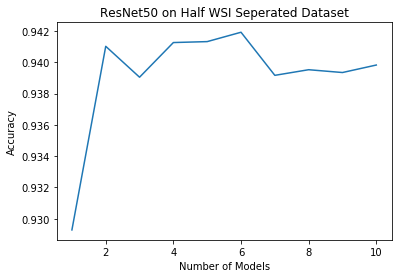

In [32]:
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t/'
models_path = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other'
models_arch = [resnet50]*10
models_name = ['resnet50_half_wsi_'+str(i)for i in range (10)]

int_acc = bagging_ensemble_acc_dir(models_arch, models_name, models_path, PATH, weights=None)
x = list(range(1, 11))

plt.plot(x, int_acc)
plt.title('ResNet50 on Half WSI Seperated Dataset')
plt.xlabel('Number of Models')
plt.ylabel('Accuracy')
plt.show()

resnet50_quarter_wsi_0 :    0.9206586826347305
resnet50_quarter_wsi_0 int acc:    0.9206586826347305
resnet50_quarter_wsi_1 :    0.9196407185628742
resnet50_quarter_wsi_1 int acc:    0.9292215568862275
resnet50_quarter_wsi_2 :    0.9168862275449102
resnet50_quarter_wsi_2 int acc:    0.9320359281437126
resnet50_quarter_wsi_3 :    0.9049700598802395
resnet50_quarter_wsi_3 int acc:    0.9324550898203593
resnet50_quarter_wsi_4 :    0.9060479041916167
resnet50_quarter_wsi_4 int acc:    0.932934131736527
resnet50_quarter_wsi_5 :    0.9322155688622754
resnet50_quarter_wsi_5 int acc:    0.9350898203592815
resnet50_quarter_wsi_6 :    0.9050898203592814
resnet50_quarter_wsi_6 int acc:    0.9356287425149701
resnet50_quarter_wsi_7 :    0.9045508982035928
resnet50_quarter_wsi_7 int acc:    0.9359281437125748
resnet50_quarter_wsi_8 :    0.8638323353293413
resnet50_quarter_wsi_8 int acc:    0.9340718562874252
resnet50_quarter_wsi_9 :    0.8998203592814371
resnet50_quarter_wsi_9 int acc:    0.93347305

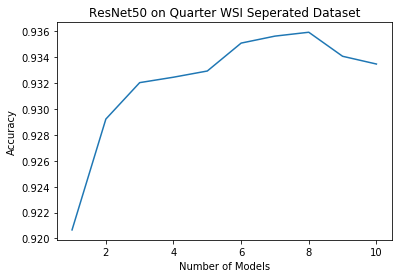

In [33]:
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t/'
models_path = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other'
models_arch = [resnet50]*10
models_name = ['resnet50_quarter_wsi_'+str(i)for i in range (10)]

int_acc = bagging_ensemble_acc_dir(models_arch, models_name, models_path, PATH, weights=None)
x = list(range(1, 11))

plt.plot(x, int_acc)
plt.title('ResNet50 on Quarter WSI Seperated Dataset')
plt.xlabel('Number of Models')
plt.ylabel('Accuracy')
plt.show()

resnet50_eighth_wsi_0 :    0.8712574850299402
resnet50_eighth_wsi_0 int acc:    0.8712574850299402
resnet50_eighth_wsi_1 :    0.904311377245509
resnet50_eighth_wsi_1 int acc:    0.9059880239520958
resnet50_eighth_wsi_3 :    0.8925748502994012
resnet50_eighth_wsi_3 int acc:    0.9147305389221557
resnet50_eighth_wsi_4 :    0.8685029940119761
resnet50_eighth_wsi_4 int acc:    0.9116766467065869
resnet50_eighth_wsi_5 :    0.8724550898203592
resnet50_eighth_wsi_5 int acc:    0.91
resnet50_eighth_wsi_6 :    0.9059880239520958
resnet50_eighth_wsi_6 int acc:    0.9138323353293413
resnet50_eighth_wsi_7 :    0.8931137724550898
resnet50_eighth_wsi_7 int acc:    0.9202395209580838
resnet50_eighth_wsi_8 :    0.9065868263473054
resnet50_eighth_wsi_8 int acc:    0.9251497005988024
resnet50_eighth_wsi_9 :    0.864191616766467
resnet50_eighth_wsi_9 int acc:    0.9230538922155689
0.9230538922155689


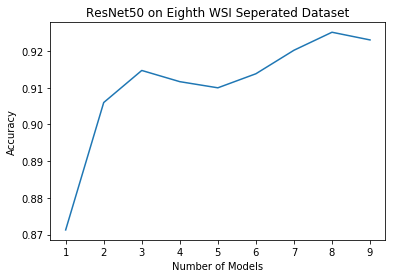

In [37]:
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t/'
models_path = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other'
models_arch = [resnet50]*9
models_name = ['resnet50_eighth_wsi_'+str(i)for i in [0,1,3,4,5,6,7,8,9]]

int_acc = bagging_ensemble_acc_dir(models_arch, models_name, models_path, PATH, weights=None)
x = list(range(1, 10))

plt.plot(x, int_acc)
plt.title('ResNet50 on Eighth WSI Seperated Dataset')
plt.xlabel('Number of Models')
plt.ylabel('Accuracy')
plt.show()

## Standard Bagging with WSI
* Sample WSIs with replacement, same number as full dataset.

In [5]:
# get the indices of slides to use
def make_sample_replacement(labels_df, normal_train, tumor_train, downsample=2):
    normal_train_subset = np.random.choice(normal_train, len(normal_train))
    normal_train_subset = [int(x) for x in normal_train_subset]
    
    tumor_train_subset = np.random.choice(tumor_train, len(tumor_train))
    tumor_train_subset = [int(x) for x in tumor_train_subset]
    
    drop_rows = []
    for index, row in labels_df.iterrows():
        label = row['label']
        num = int(row['file_name'].split('_', 1)[1].split('_', 1)[0])
        
        if label == 'normal' and num not in normal_train_subset:
            drop_rows.append(index)
        elif label == 'tumor' and num not in tumor_train_subset:
            drop_rows.append(index)
    
    subset_labels_df = labels_df.drop(labels_df.index[drop_rows])
    return subset_labels_df

In [ ]:
models_arch = resnet18
models_name = 'resnet18'

lr=np.array([1e-3,5e-3,1e-2])

sz = 224
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other'
train_folder = '/media/rene/Data/camelyon_out/tiles_224_100t_all'

for i in tqdm(range(10, 15)):
    # create the new csv and save it
    subset_labels_df = make_sample_replacement(labels_df, normal_train, tumor_train)
    subset_labels_df.to_csv('/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp2.csv',  
                            index = False)
    csv_fname = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp2.csv'
    
    # get the validation indices based on this
    val_idxs = make_validation_mask(subset_labels_df, normal_valid, tumor_valid)

    tfms = tfms_from_model(models_arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
    data = ImageClassifierData.from_csv(PATH, train_folder, csv_fname, tfms=tfms, 
                                        val_idxs=val_idxs, bs=128)
    learn = ConvLearner.pretrained(models_arch, data, precompute=False)
    
    lr =.001
    learn.fit(lr, 1, cycle_len=1, cycle_mult=1) # train last few layers
    lrs = np.array([lr/4,lr/2,lr])
    learn.unfreeze()
    learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name+'_bagging_proper_wsi_'+str(i)) # train whole model

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

epoch      trn_loss   val_loss   accuracy                    
    0      0.303586   0.26227    0.891908  



epoch      trn_loss   val_loss   accuracy                    
    0      0.246768   0.22702    0.905894  
    1      0.219619   0.196038   0.922677                    
    2      0.204463   0.192088   0.924076                    
    3      0.191473   0.181394   0.928871                    
    4      0.189459   0.176      0.927672                    
    5      0.178979   0.175404   0.929071                    


 20%|██        | 1/5 [17:55<1:11:41, 1075.49s/it]

    6      0.178621   0.173561   0.931069  



epoch      trn_loss   val_loss   accuracy                    
    0      0.316013   0.272014   0.885086  



epoch      trn_loss   val_loss   accuracy                    
    0      0.256364   0.223344   0.905495  
    1      0.22047    0.191064   0.918681                    
    2      0.208122   0.187783   0.922763                    
    3      0.19095    0.178684   0.925432                    
    4      0.18874    0.168514   0.93281                     
    5      0.1822     0.166081   0.932339                    


 40%|████      | 2/5 [35:39<53:29, 1069.99s/it]  

    6      0.185036   0.168756   0.931083  



epoch      trn_loss   val_loss   accuracy                    
    0      0.310994   0.262538   0.894505  



epoch      trn_loss   val_loss   accuracy                    
    0      0.254063   0.209205   0.911774  
    1      0.213229   0.173254   0.928728                    
    2      0.198619   0.170055   0.930298                    
    3      0.182448   0.158144   0.939403                    
    4      0.176268   0.152095   0.941601                    
    5      0.173545   0.148307   0.943485                    


 60%|██████    | 3/5 [54:17<36:11, 1085.71s/it]

    6      0.170409   0.149654   0.941287  



epoch      trn_loss   val_loss   accuracy                    
    0      0.332892   0.289354   0.878681  



epoch      trn_loss   val_loss   accuracy                    
    0      0.267732   0.230144   0.902637  
    1      0.237092   0.206564   0.916484                    
    2      0.223482   0.200381   0.916923                    
    3      0.202618   0.184569   0.922198                    
    4      0.203909   0.178505   0.925055                    
    5      0.194919   0.177799   0.924396                    


 80%|████████  | 4/5 [1:11:23<17:50, 1070.76s/it]

    6      0.19858    0.178692   0.924176  



epoch      trn_loss   val_loss   accuracy                    
    0      0.311349   0.268104   0.885495  



 27%|██▋       | 94/348 [00:33<01:31,  2.76it/s, loss=0.31] 

In [ ]:
models_arch = resnet50
models_name = 'resnet50'

lr=np.array([1e-3,5e-3,1e-2])

sz = 224
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other'
train_folder = '/media/rene/Data/camelyon_out/tiles_224_100t_all'

for i in tqdm(range(15)):
    # create the new csv and save it
    subset_labels_df = make_sample_replacement(labels_df, normal_train, tumor_train)
    subset_labels_df.to_csv('/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp2.csv',  
                            index = False)
    csv_fname = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp2.csv'
    
    # get the validation indices based on this
    val_idxs = make_validation_mask(subset_labels_df, normal_valid, tumor_valid)

    tfms = tfms_from_model(models_arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
    data = ImageClassifierData.from_csv(PATH, train_folder, csv_fname, tfms=tfms, 
                                        val_idxs=val_idxs, bs=64)
    learn = ConvLearner.pretrained(models_arch, data, precompute=False)
    
    lr =.001
    learn.fit(lr, 1, cycle_len=1, cycle_mult=1) # train last few layers
    lrs = np.array([lr/4,lr/2,lr])
    learn.unfreeze()
    learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name+'_bagging_proper_wsi_'+str(i)) # train whole model

In [ ]:
models_arch = dn169
models_name = 'dn169'

lr=np.array([1e-3,5e-3,1e-2])

sz = 224
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other'
train_folder = '/media/rene/Data/camelyon_out/tiles_224_100t_all'

for i in tqdm(range(13, 15)):
    # create the new csv and save it
    subset_labels_df = make_sample_replacement(labels_df, normal_train, tumor_train)
    subset_labels_df.to_csv('/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp2.csv',  
                            index = False)
    csv_fname = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp2.csv'
    
    # get the validation indices based on this
    val_idxs = make_validation_mask(subset_labels_df, normal_valid, tumor_valid)

    tfms = tfms_from_model(models_arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
    data = ImageClassifierData.from_csv(PATH, train_folder, csv_fname, tfms=tfms, 
                                        val_idxs=val_idxs, bs=48)
    learn = ConvLearner.pretrained(models_arch, data, precompute=False)
    
    lr =.001
    learn.fit(lr, 1, cycle_len=1, cycle_mult=1) # train last few layers
    lrs = np.array([lr/4,lr/2,lr])
    learn.unfreeze()
    learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name+'_bagging_proper_wsi_'+str(i)) # train whole model

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/986 [00:00<?, ?it/s]

epoch      trn_loss   val_loss   accuracy                    
    0      0.249017   0.216515   0.907493  



epoch      trn_loss   val_loss   accuracy                    
    0      0.19583    0.178313   0.930869  
    1      0.181065   0.15699    0.935864                    
    2      0.164168   0.152913   0.938262                    
    3      0.142469   0.142039   0.942458                    
    4      0.155367   0.137674   0.946254                    
    5      0.137972   0.132742   0.948851                    


 50%|█████     | 1/2 [49:40<49:40, 2980.44s/it]

    6      0.135903   0.132269   0.946853  



epoch      trn_loss   val_loss   accuracy                    
    0      0.249105   0.21259    0.909576  



epoch      trn_loss   val_loss   accuracy                    
    0      0.217661   0.178476   0.926688  
    1      0.181426   0.153965   0.938305                    
    2      0.162695   0.148798   0.943014                    
    3      0.16952    0.140335   0.944584                    
    4      0.154633   0.130883   0.948509                    
    5      0.139956   0.126873   0.949294                    
 62%|██████▏   | 604/976 [03:51<02:22,  2.61it/s, loss=0.137]

## Results

resnet18_bagging_proper_wsi_0 :    0.9279640718562874
resnet18_bagging_proper_wsi_0 int acc:    0.9279640718562874
resnet18_bagging_proper_wsi_1 :    0.9259880239520958
resnet18_bagging_proper_wsi_1 int acc:    0.9299401197604791
resnet18_bagging_proper_wsi_2 :    0.9306586826347305
resnet18_bagging_proper_wsi_2 int acc:    0.9331736526946108
resnet18_bagging_proper_wsi_3 :    0.9332934131736527
resnet18_bagging_proper_wsi_3 int acc:    0.9346107784431138
resnet18_bagging_proper_wsi_4 :    0.9268862275449102
resnet18_bagging_proper_wsi_4 int acc:    0.9335329341317365
resnet18_bagging_proper_wsi_5 :    0.9264670658682634
resnet18_bagging_proper_wsi_5 int acc:    0.932814371257485
resnet18_bagging_proper_wsi_6 :    0.9226347305389222
resnet18_bagging_proper_wsi_6 int acc:    0.9325748502994012
resnet18_bagging_proper_wsi_7 :    0.9261676646706587
resnet18_bagging_proper_wsi_7 int acc:    0.9325748502994012
resnet18_bagging_proper_wsi_8 :    0.9286826347305389
resnet18_bagging_proper_wsi

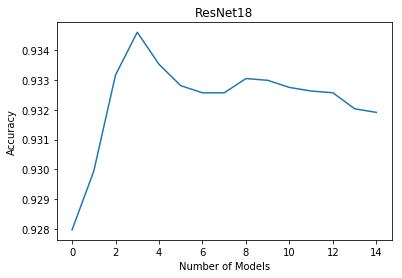

In [12]:
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t/'
models_path = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other'
models_arch = [resnet18]*15
models_name = ['resnet18_bagging_proper_wsi_'+str(i) for i in range (15)]

int_acc = bagging_ensemble_acc_dir(models_arch, models_name, models_path, PATH, weights=None)
x = list(range(15))

plt.plot(x, int_acc)
plt.title('ResNet18')
plt.xlabel('Number of Models')
plt.ylabel('Accuracy')
plt.show()

resnet50_bagging_proper_wsi_0 :    0.9338323353293413
resnet50_bagging_proper_wsi_0 int acc:    0.9338323353293413
resnet50_bagging_proper_wsi_1 :    0.9302395209580838
resnet50_bagging_proper_wsi_1 int acc:    0.9368263473053893
resnet50_bagging_proper_wsi_2 :    0.9411976047904191
resnet50_bagging_proper_wsi_2 int acc:    0.941497005988024
resnet50_bagging_proper_wsi_3 :    0.938562874251497
resnet50_bagging_proper_wsi_3 int acc:    0.9425149700598803
resnet50_bagging_proper_wsi_4 :    0.9332335329341317
resnet50_bagging_proper_wsi_4 int acc:    0.9425748502994012
resnet50_bagging_proper_wsi_5 :    0.9275449101796407
resnet50_bagging_proper_wsi_5 int acc:    0.9421556886227545
resnet50_bagging_proper_wsi_6 :    0.9376047904191617
resnet50_bagging_proper_wsi_6 int acc:    0.9426946107784431
resnet50_bagging_proper_wsi_7 :    0.9381437125748503
resnet50_bagging_proper_wsi_7 int acc:    0.9426946107784431
resnet50_bagging_proper_wsi_8 :    0.9364071856287425
resnet50_bagging_proper_wsi_

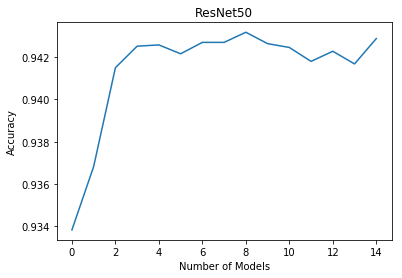

In [13]:
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t/'
models_path = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other'
models_arch = [resnet50]*15
models_name = ['resnet50_bagging_proper_wsi_'+str(i) for i in range (15)]

int_acc = bagging_ensemble_acc_dir(models_arch, models_name, models_path, PATH, weights=None)
x = list(range(15))

plt.plot(x, int_acc)
plt.title('ResNet50')
plt.xlabel('Number of Models')
plt.ylabel('Accuracy')
plt.show()

In [14]:
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t/'
models_path = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other'
models_arch = [dn169]*15
models_name = ['dn169_bagging_proper_wsi_'+str(i) for i in range (15)]

int_acc = bagging_ensemble_acc_dir(models_arch, models_name, models_path, PATH, weights=None)
x = list(range(15))

plt.plot(x, int_acc)
plt.title('dn169')
plt.xlabel('Number of Models')
plt.ylabel('Accuracy')
plt.show()

dn169_bagging_proper_wsi_0 :    0.9379041916167664
dn169_bagging_proper_wsi_0 int acc:    0.9379041916167664
dn169_bagging_proper_wsi_1 :    0.9311976047904191
dn169_bagging_proper_wsi_1 int acc:    0.9396407185628742
dn169_bagging_proper_wsi_2 :    0.9412574850299401
dn169_bagging_proper_wsi_2 int acc:    0.9435928143712575
dn169_bagging_proper_wsi_3 :    0.9425149700598803
dn169_bagging_proper_wsi_3 int acc:    0.9446706586826348
dn169_bagging_proper_wsi_4 :    0.9386826347305389
dn169_bagging_proper_wsi_4 int acc:    0.9449700598802395
dn169_bagging_proper_wsi_5 :    0.9376047904191617
dn169_bagging_proper_wsi_5 int acc:    0.944251497005988
dn169_bagging_proper_wsi_6 :    0.9390419161676646
dn169_bagging_proper_wsi_6 int acc:    0.9454491017964072
dn169_bagging_proper_wsi_7 :    0.9376047904191617
dn169_bagging_proper_wsi_7 int acc:    0.9453293413173652
dn169_bagging_proper_wsi_8 :    0.9199401197604791
dn169_bagging_proper_wsi_8 int acc:    0.9448502994011976
dn169_bagging_proper

FileNotFoundError: [Errno 2] No such file or directory: '/media/rene/Data/camelyon_out/tiles_224_100t_all_other/models/dn169_bagging_proper_wsi_13.h5'

# Baseline without bagging. 
Just model averaraging without this batch generator

In [ ]:
models_arch = resnet18
models_name = 'resnet18'

lr=np.array([1e-3,5e-3,1e-2])

sz = 224
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other'
train_folder = '/media/rene/Data/camelyon_out/tiles_224_100t_all'

for i in tqdm(range(0, 15)):
    # create the new csv and save it
    labels_df.to_csv('/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp2.csv',  
                            index = False)
    csv_fname = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp2.csv'
    
    # get the validation indices based on this
    val_idxs = make_validation_mask(labels_df, normal_valid, tumor_valid)

    tfms = tfms_from_model(models_arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
    data = ImageClassifierData.from_csv(PATH, train_folder, csv_fname, tfms=tfms, 
                                        val_idxs=val_idxs, bs=128)
    learn = ConvLearner.pretrained(models_arch, data, precompute=False)
    
    lr =.001
    learn.fit(lr, 1, cycle_len=1, cycle_mult=1) # train last few layers
    lrs = np.array([lr/4,lr/2,lr])
    learn.unfreeze()
    learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name+'_no_bagging_proper_wsi_'+str(i)) # train whole model

In [ ]:
models_arch = dn169
models_name = 'dn169'

lr=np.array([1e-3,5e-3,1e-2])

sz = 224
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other'
train_folder = '/media/rene/Data/camelyon_out/tiles_224_100t_all'

for i in tqdm(range(15)):
    # create the new csv and save it
    labels_df.to_csv('/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp2.csv',  
                            index = False)
    csv_fname = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp2.csv'
    
    # get the validation indices based on this
    val_idxs = make_validation_mask(labels_df, normal_valid, tumor_valid)

    tfms = tfms_from_model(models_arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
    data = ImageClassifierData.from_csv(PATH, train_folder, csv_fname, tfms=tfms, 
                                        val_idxs=val_idxs, bs=48)
    learn = ConvLearner.pretrained(models_arch, data, precompute=False)
    
    lr =.001
    learn.fit(lr, 1, cycle_len=1, cycle_mult=1) # train last few layers
    lrs = np.array([lr/4,lr/2,lr])
    learn.unfreeze()
    learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name+'_no_bagging_proper_wsi_'+str(i)) # train whole model

## 

In [6]:
models_arch = [resnet50]*10
models_name = ['resnet50_full_'+str(i)for i in range (10)]
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other'
train_folder = '/media/rene/Data/camelyon_out/tiles_224_100t_all'
csv_fname = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_labels.csv'
val_idxs = pickle.load( open( "/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_val_idxs.p", 'rb'))

int_acc = bagging_ensemble_acc(models_arch, models_name, PATH, train_folder, csv_fname, weights=None)
x = list(range(1, 10))

plt.plot(x, int_acc)
plt.title('ResNet50 on Full Dataset')
plt.xlabel('Number of Models')
plt.ylabel('Accuracy')
plt.show()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      )
    )
    (1): Bot

RuntimeError: While copying the parameter named 16.weight, whose dimensions in the model are torch.Size([100000, 512]) and whose dimensions in the checkpoint are torch.Size([2, 512]).